# Pipeline

imports

In [351]:
import json
import os
import csv
import time
import numpy as np
import datetime
import random
import shutil
# from scipy.stats import norm
from itertools import product 
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import yaml
# from ruamel.yaml import YAML

In [352]:
import sys
print(sys.path)
src_path = os.path.join(os.getcwd(), 'src')
sys.path.append(src_path)
# print(src_path)

['/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python39.zip', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9/lib-dynload', '', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9/site-packages', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9/site-packages/setuptools/_vendor', '/opt/gurobi201/linux32/lib/python2.5', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src', '/Users/I583318/Library/CloudStorage/OneDrive-SAPSE/Development/phd/robustness/src']


In [353]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [354]:
# from src.utils import LogColumnNames
from src.log_stats_calculation import *
from src.simulators.param_manipulation import *
from src.sim_execution_and_evalaution import *
from src.logging import log_simulation, initialize_simulation_log, save_params, set_up_experiment_output_dir, save_simulation_log
from src.search_strategies.grid_search import run_grid_search
from src.simulators.simod_discovery import discover_BPS_simod
# from src.logging import *
from src.evaluation import generate_and_plot_quadtree_metrics, plot_quadtree_metrics_over_depth, evaluate_quadtree_vs_simulation_log
from src.search_strategies.quadtree import adaptive_quadtree, plot_quadtree, write_nodes_visited_to_json, write_quadtree_nodes_to_file

In [355]:
from prosimos import simulation_engine, simulation_properties_parser
# from simod.simod import Simod
# from simod.event_log.event_log import EventLog
# from simod.settings.simod_settings import SimodSettings
from simod.simulation.prosimos import *


# Pipeline

## 0. Input

In [389]:
# - event_log: historical process data
# - target_PPI: performance metric (e.g., cycle time)
# - PPI_target_range: acceptable range (e.g., [0, 5])
# - simulation_tool: engine for discrete-event simulation
# - changeable_parameters_list: list of parameters to vary
# # - simulation_model: built from event_log


# Inputs
# process_name = 'dummy_2tasks'
# process_name = 'ten_activities'
# process_name = 'LoanApp'
# process_name = 'LoanApp_SingleRole'
process_name = 'LoanApp_SingleRole_fixDuration'
# process_name = 'LoanApp_TwoRoles'

# target_ppi = 'cycle_time'
# target_ppi = 'idle_cycle_time'

# target_ppis = ['idle_cycle_time', 'cost']
target_ppis = ['lead_time', 'cost']
# target_ppis = ['lead_time']
# target_ppis = ['cost']

ppi_range_factor = 0.35

cases_to_simulate = 1000
discover_bps_model = False
nr_simulations_per_scenario = 1
execute_strategy = ['grid_search', 'quadtree', 'hyperquadtree'] # , 'diagonal_search', 'hill_climbing'

confidence = 0.95
calculate_stats = 'custom'  # 'custom' or 'simod'
dt = datetime.datetime(2025, 6, 23, 9, 0, tzinfo=datetime.timezone.utc)
simulation_tool = 'simod'

print_intermediate_results = True

# internal parameters
decimals = 2
# retain_simulation_data = False
simulation_results_confidence = True
in_out_criteria = "confidence"  # "mean" or "confidence"
simod_config_path = 'simulators/simod/resources/config/config_one-shot.yml'
simod_directory = 'simulators/simod'
ppi_calculation = {
    'cost': {
        'type': 'total',
        'method': 'full_duration', # full_duration, active_time, combined
        'weight': 1.5         # only applicable for 'combined' method
    },
    'lead_time': {
        'type': 'avg'}
    }




In [390]:
# Write inputs into 
base_path = os.path.join('data', process_name)

dt_str = dt.strftime("%Y-%m-%dT%H:%M:%SZ")

params = {
    'process_name': process_name,
    'base_path': base_path,
    'target_ppis': target_ppis,
    'ppi_range_factor': ppi_range_factor,
    'cases_to_simulate': cases_to_simulate,
    'starting_at':dt_str,
    'simulation_tool': simulation_tool,
    'nr_simulations_per_scenario': nr_simulations_per_scenario,
    'decimals': decimals,
    'simulation_results_confidence': simulation_results_confidence,
    'calculate_stats': calculate_stats,
    'confidence': confidence,
    'in_out_criteria': in_out_criteria,
    'print_intermediate_results': print_intermediate_results,
    'execute_strategy': execute_strategy,
    'simod_config_path': simod_config_path,
    'simod_directory': simod_directory,
    'ppi_calculation': ppi_calculation
}


results = {}

In [391]:


params['strategies'] = {
    'grid_search': {
        'granularity': 10,
        'input': 'original_input' 
    },
    'hyperquadtree': {
        'min_depth': 2,
        'max_depth': 4
    },
    'quadtree': {
        'min_depth': 2,
        'max_depth': 4
    },
    'diagonal_search': {
        'stepsize_initial': 0.1,
        'step_max': 20,
        'adaptive_step': True,
        'strictness': 0.01
    },
    'hill_climbing': {
        'stepsize_initial': 0.1,
        'step_max': 20,
        # 'adaptive_step': True,
        'candidate_strategy': 'random_one',
        'walk_reps_max': 100
    }
}

In [392]:
# params[cases_to_simulate] = 100
# params['nr_simulations_per_scenario'] = 1
# params['confidence'] = confidence
# params['print_intermediate_results'] = False
# params['target_ppis'] = ['lead_time', 'cost']
# params['execute_strategy'] = ['grid_search', 'quadtree', 'hyperquadtree']
# ppi = 'cost'
# metric_type = params['ppi_calculation'][ppi]['type']
# calculation_method = params['ppi_calculation'][ppi]['type']
# metric_type, calculation_method

### 0.5 Discovery

#### implement automatic calling of discovery

In [393]:
# def copy_simod_files(params):
#     """
#     Copies the BPMN and JSON files from the 'best_result' directory to the base directory.

#     Args:
#         params (dict): Dictionary containing configuration parameters, including 'print_intermediate_results'.

#     Returns:
#         None
#     """

#     base_path = params['base_path']
#     process_name = params['process_name']

#     # Define source paths
#     bpmn_src = os.path.join(base_path, 'best_result', process_name + '.bpmn')
#     json_src = os.path.join(base_path, 'best_result', process_name + '.json')

#     # Define destination paths
#     bpmn_dest = os.path.join(base_path, process_name + '.bpmn')
#     json_dest = os.path.join(base_path, process_name + '.json')

#     # Helper function to conditionally print messages
#     def conditional_print(message):
#         if params.get('print_intermediate_results', False):
#             print(message)

#     # Copy the BPMN file
#     try:
#         shutil.copy(bpmn_src, bpmn_dest)
#         conditional_print(f"Copied BPMN file from {bpmn_src} to {bpmn_dest}")
#     except FileNotFoundError:
#         conditional_print(f"Error: BPMN file not found at {bpmn_src}")
#     except Exception as e:
#         conditional_print(f"Error copying BPMN file: {e}")

#     # Copy the JSON file
#     try:
#         shutil.copy(json_src, json_dest)
#         conditional_print(f"Copied JSON file from {json_src} to {json_dest}")
#     except FileNotFoundError:
#         conditional_print(f"Error: JSON file not found at {json_src}")
#     except Exception as e:
#         conditional_print(f"Error copying JSON file: {e}")

In [394]:
if discover_bps_model:

    discover_BPS_simod(params)

    # # Read and update the simod configuration file: set train_log_path
    # update_simod_config_train_path(params)

    # # Specify the path to the simod directory
    # simod_directory = os.path.join('simulators', 'simod')

    # # output = Path(os.path.join(simod_directory, 'resources', 'output'))
    # output = Path(os.path.join(params['base_path']))

    # configuration_path = Path(os.path.join(simod_directory, 'resources', 'config', 'config_one-shot.yml' ))
    # settings = SimodSettings.from_path(configuration_path)

    # # Read and preprocess event log
    # event_log = EventLog.from_path(
    #     log_ids=settings.common.log_ids,
    #     train_log_path=settings.common.train_log_path,
    #     # test_log_path=settings.common.test_log_path,
    #     preprocessing_settings=settings.preprocessing,
    #     need_test_partition=settings.common.perform_final_evaluation,
    # )

    # # Instantiate and run SIMOD
    # simod = Simod(settings=settings, event_log=event_log, output_dir=output)
    # simod.run()

    # # Copy the discovered model to the process data folder
    # copy_simod_files(params)

In [395]:
# reading in of temp BPS_model json file

# dt = datetime.datetime(2025, 6, 23, 9, 0, tzinfo=datetime.timezone.utc)
# dt_str = dt.strftime("%Y-%m-%dT%H:%M:%SZ")

# if discover_bps_model:
#     bpmn_path = os.path.join(base_path, 'best_result', process_name + '.bpmn')
#     json_path = os.path.join(base_path, 'best_result', process_name + '.json')



# else:      
bpmn_path = os.path.join(params['base_path'], params['process_name'] + '.bpmn')
json_path = os.path.join(params['base_path'], params['process_name'] + '.json')


params['json_path'] = json_path
json_path_temp = create_temp_json(input_path=json_path, output_path=None)
params['bpmn_path'] = bpmn_path
params['json_path_temp'] = json_path_temp


##### BPMN plotting

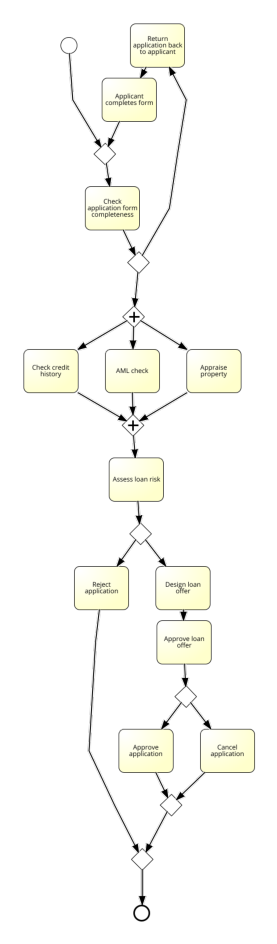

In [396]:

# Specify the path to your PNG file
name = params['process_name']
image_path = os.path.join(params['base_path'],  f'{name}.png')

try:
    # Load and display the image
    img = mpimg.imread(image_path)
    fig = plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis
    plt.show()
except:
    print(f"Image file not found at {image_path}")

## 1.  Set up

### Required Input

In [397]:

# parameters to change


''''
Possible values: 
    - continous ("cont"),
    - discrete ("disc"), 
    - categorical ("cat").

Define ranges for each parameter:
    - continuous: [min, max]    
    - discrete: [min, max]
    - categorical: [list of possible values]
'''

input_parameters = {
    'arriaval_distr_mean': {
        'type': 'cont',
        'values': [60*5, 60*60*4]  # 5 min to 3 hours
    },  
    'resource_count': {
        'type': 'disc',
        'values': [1, 25],  # 1 to 26 resources
        'ignore': ['applicant']
    }
}

ppi_bounds = {
    'lead_time': 'upper',
    'cost': 'upper'
}


### Adaptation based on input ranges and parameters to change

In [398]:
# Determine which parameter to update
params_to_change = {}

if 'resource_count' in input_parameters:
    update_parameter = 'resource_count'
    sim_params = get_sim_params(params['json_path'])
    params_to_change = set_params_to_change(input_parameters, update_parameter, sim_params) 

    if params['print_intermediate_results']:
        print("\nInput parameters:")  
        print(input_parameters)
        print("Parameters to change:")
        print(params_to_change)
        print()

else:
    params_to_change = input_parameters

# Add params_to_change to params dictionary
params['params_to_change'] = params_to_change

# Initialize a global DataFrame to store simulation logs
simulation_log = initialize_simulation_log(params['params_to_change'])



Input parameters:
{'arriaval_distr_mean': {'type': 'cont', 'values': [300, 14400]}, 'resource_count': {'type': 'disc', 'values': [1, 25], 'ignore': ['applicant']}}
Parameters to change:
{'arriaval_distr_mean': {'type': 'cont', 'values': [300, 14400]}, 'resource_count_UnifiedResourceProfile': {'type': 'disc', 'values': [1, 25]}}



### Set up background

In [399]:
# Set up experiment output directory
params = set_up_experiment_output_dir(params)

Output directory ensured at: data/LoanApp_SingleRole_fixDuration/output/20251112_183457


In [400]:
#######################

# Intermediate output

# Get the initial target PPI value
target_ppi_dict = get_simulation_stats(params)

orig_target_ppi_val_dict = {}
target_range_dict = {}

for ppi in params['target_ppis']:
    target_ppi_list = target_ppi_dict[ppi]
    target_ppi_val = np.mean(target_ppi_list)
    orig_target_ppi_val_dict[ppi] = target_ppi_val
    
    # calculate ppi bounds
    target_range = [np.round(target_ppi_val*(1-params['ppi_range_factor'])), np.round(target_ppi_val*(1+params['ppi_range_factor']))]
    # adjust target range based on ppi_bounds
    if ppi_bounds[ppi]=='upper':
        target_range = [0, target_range[1]]
    elif ppi_bounds[ppi]=='lower':
        target_range = [target_range[0], float('inf')]
    elif ppi_bounds[ppi]=='both':
        pass
    else:
        raise ValueError(f"Unknown ppi_bounds value: {ppi_bounds[ppi]}")
    target_range_dict[ppi] = target_range

params['orig_target_ppi_val_dict'] = orig_target_ppi_val_dict
params['target_range'] = target_range_dict


simulation_log = log_simulation(
    simulation_log=simulation_log,
    algorithm='orig_run',
    params=params,
    target_ppi_dict=target_ppi_dict,
    param_values=get_start_param_settings(params_to_change, params),
)

for ppi in params['target_ppis']:
    print(f'average {ppi}: {orig_target_ppi_val_dict[ppi]}h')
    print(f'range: {target_range_dict[ppi]}h')


average lead_time: 48854.7h
range: [0, 65954.0]h
average cost: 170398.33333333334h
range: [0, 230038.0]h


In [401]:
# # Save paramas to json file in data/process_name/output/params.json
save_params(params)

# Write simulation log to CSV
simulation_log.to_csv(params['simulation_log_path'], index=False)

Parameters saved to data/LoanApp_SingleRole_fixDuration/output/20251112_183457/params.json


In [402]:
params

{'process_name': 'LoanApp_SingleRole_fixDuration',
 'base_path': 'data/LoanApp_SingleRole_fixDuration',
 'target_ppis': ['lead_time', 'cost'],
 'ppi_range_factor': 0.35,
 'cases_to_simulate': 1000,
 'starting_at': '2025-06-23T09:00:00Z',
 'simulation_tool': 'simod',
 'nr_simulations_per_scenario': 1,
 'decimals': 2,
 'simulation_results_confidence': True,
 'calculate_stats': 'custom',
 'confidence': 0.95,
 'in_out_criteria': 'confidence',
 'print_intermediate_results': True,
 'execute_strategy': ['grid_search', 'quadtree', 'hyperquadtree'],
 'simod_config_path': 'simulators/simod/resources/config/config_one-shot.yml',
 'simod_directory': 'simulators/simod',
 'ppi_calculation': {'cost': {'type': 'total',
   'method': 'full_duration',
   'weight': 1.5},
  'lead_time': {'type': 'avg'}},
 'strategies': {'grid_search': {'granularity': 10, 'input': 'original_input'},
  'hyperquadtree': {'min_depth': 2, 'max_depth': 4},
  'quadtree': {'min_depth': 2, 'max_depth': 4},
  'diagonal_search': {'st

In [403]:
simulation_log

,algorithm,simulation_id,timestamp,target_range,status,target_ppis,target_ppi_means,target_ppi_dict,arriaval_distr_mean,resource_count_UnifiedResourceProfile
0,orig_run,0,2025-11-12T17:34:57.778597Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",True,"[lead_time, cost]","{'lead_time': 48854.7, 'cost': 170398.33333333...","{'lead_time': [48854.7], 'cost': [170398.33333...",1800.0,19


## 2. Search

### Helper functions

### Search strategies

#### Grid Search Pipeline

In [404]:

%time

if 'grid_search' in params['execute_strategy']:

    # Start the timer
    start_time = time.perf_counter()

    simulation_log = run_grid_search(params, simulation_log=simulation_log)

    # End the timer
    end_time = time.perf_counter()

    # Calculate elapsed time
    elapsed_time = end_time - start_time


    save_simulation_log(simulation_log, params)



CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.62 µs

Grid search ranges generated:
  arriaval_distr_mean: [300.0, 1866.6666666666667, 3433.3333333333335, 5000.0, 6566.666666666667, 8133.333333333334, 9700.0, 11266.666666666668, 12833.333333333334, 14400.0]
  resource_count_UnifiedResourceProfile: [1, 3, 6, 9, 11, 14, 17, 19, 22, 25]
Total combinations to test: 100
Grid-search progress: 10% (10/100 combinations tested)
Grid-search progress: 20% (20/100 combinations tested)
Grid-search progress: 30% (30/100 combinations tested)
Grid-search progress: 40% (40/100 combinations tested)
Grid-search progress: 50% (50/100 combinations tested)
Grid-search progress: 60% (60/100 combinations tested)
Grid-search progress: 70% (70/100 combinations tested)
Grid-search progress: 80% (80/100 combinations tested)
Grid-search progress: 90% (90/100 combinations tested)
Grid-search progress: 100% (100/100 combinations tested)
Simulation log saved to data/LoanApp_SingleRole_fixDuration/output/20

In [405]:
simulation_log.head(10)

,algorithm,simulation_id,timestamp,target_range,status,target_ppis,target_ppi_means,target_ppi_dict,arriaval_distr_mean,resource_count_UnifiedResourceProfile
0,orig_run,0,2025-11-12T17:34:57.778597Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",True,"[lead_time, cost]","{'lead_time': 48854.7, 'cost': 170398.33333333...","{'lead_time': [48854.7], 'cost': [170398.33333...",1800.0,19
1,grid_search,1,2025-11-12T17:34:58.402374Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 78972468.1, 'cost': 125364.44444...","{'lead_time': [78972468.1], 'cost': [125364.44...",300.0,1
2,grid_search,2,2025-11-12T17:34:58.938400Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 25639814.0, 'cost': 125748.33333...","{'lead_time': [25639814.0], 'cost': [125748.33...",300.0,3
3,grid_search,3,2025-11-12T17:34:59.538857Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 12414792.2, 'cost': 124970.00000...","{'lead_time': [12414792.2], 'cost': [124970.00...",300.0,6
4,grid_search,4,2025-11-12T17:34:59.982624Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 7824862.8, 'cost': 126010.0}","{'lead_time': [7824862.8], 'cost': [126010.0]}",300.0,9
5,grid_search,5,2025-11-12T17:35:00.522841Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 6239900.7, 'cost': 125063.888888...","{'lead_time': [6239900.7], 'cost': [125063.888...",300.0,11
6,grid_search,6,2025-11-12T17:35:01.059660Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 4664528.7, 'cost': 124740.0}","{'lead_time': [4664528.7], 'cost': [124740.0]}",300.0,14
7,grid_search,7,2025-11-12T17:35:01.769515Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 3755559.9, 'cost': 126470.555555...","{'lead_time': [3755559.9], 'cost': [126470.555...",300.0,17
8,grid_search,8,2025-11-12T17:35:02.372376Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 3229574.4, 'cost': 127574.444444...","{'lead_time': [3229574.4], 'cost': [127574.444...",300.0,19
9,grid_search,9,2025-11-12T17:35:02.829726Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 2668167.7, 'cost': 127428.888888...","{'lead_time': [2668167.7], 'cost': [127428.888...",300.0,22


In [406]:
simulation_log.shape

(101, 10)

In [407]:
success_count = simulation_log[simulation_log["status"] == True].shape[0]
print(f"Number of simulation scenarios inside PPI range: {success_count}")
failed_count = simulation_log[simulation_log["status"] == False].shape[0]
print(f"Number of simulation scenarios outside PPI range: {failed_count}")

Number of simulation scenarios inside PPI range: 14
Number of simulation scenarios outside PPI range: 87


#### Hill Climbing

In [408]:
if 'hill_cimbing' in params['execute_strategy']:

    from src.search_strategies.hill_climbing import hill_descent

    # Reset the temp JSON file
    create_temp_json(input_path=params['json_path'], output_path=None)

    stepsize_initial = params['strategies']['hill_climbing']['stepsize_initial']
    step_max = params['strategies']['hill_climbing']['step_max']
    candidate_strategy = params['strategies']['hill_climbing']['candidate_strategy']
    walk_reps_max = params['strategies']['hill_climbing']['walk_reps_max'] 

    # Call the hill descent function
    hill_descent(
        params, 
        step_size_initial=stepsize_initial, 
        step_max=step_max, 
        params_to_change=params_to_change, 
        candidate_strategy=candidate_strategy, 
        walk_reps_max=walk_reps_max
        )

    # Save the simulation log to a CSV file for later analysis
    simulation_log.to_csv(params['simulation_log_path'], index=False)


In [409]:
simulation_log.tail(1)

,algorithm,simulation_id,timestamp,target_range,status,target_ppis,target_ppi_means,target_ppi_dict,arriaval_distr_mean,resource_count_UnifiedResourceProfile
100,grid_search,100,2025-11-12T17:35:48.298897Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 51577.8, 'cost': 1334958.3333333...","{'lead_time': [51577.8], 'cost': [1334958.3333...",14400.0,25


#### Hpyerquadtree

##### Functions

In [410]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Execute hyperquadtree



 # Evaluating corner at (300, 1)
  Target PPI Dict: {'lead_time': [78676914.0], 'cost': [126066.66666666666]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (300, 25)
  Target PPI Dict: {'lead_time': [2221556.8], 'cost': [126583.33333333328]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (14400, 1)
  Target PPI Dict: {'lead_time': [45261616.8], 'cost': [126138.88888888889]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (14400, 25)
  Target PPI Dict: {'lead_time': [52230.4], 'cost': [1334958.3333333333]}
  In Target Range: False, Direction: mixed
Node at depth 1 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 1 classified as out_range


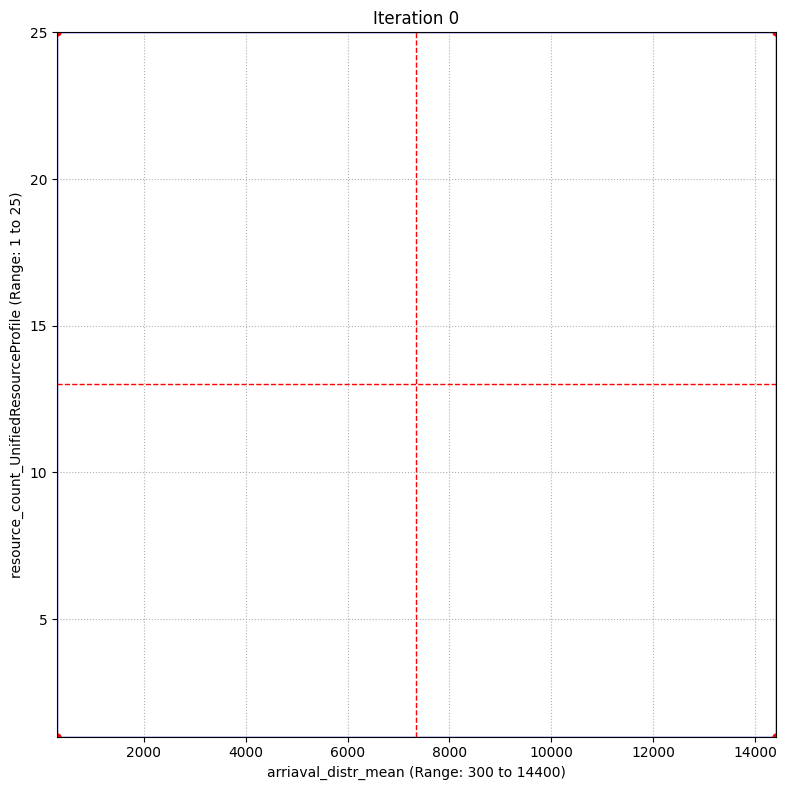



 # Evaluating corner at (300, 1)
  Target PPI Dict: {'lead_time': [78676914.0], 'cost': [126066.66666666666]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (300, 13)
  Target PPI Dict: {'lead_time': [5144752.7], 'cost': [126078.33333333331]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (7350.0, 1)
  Target PPI Dict: {'lead_time': [58356603.2], 'cost': [124887.77777777778]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (7350.0, 13)
  Target PPI Dict: {'lead_time': [56658.4], 'cost': [417018.3333333333]}
  In Target Range: False, Direction: mixed
Node at depth 2 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 2 classified as out_range


 # Evaluating corner at (300, 13)
  Target PPI Dict: {'lead_time': [5144752.7], 'cost': [126078.33333333331]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (300, 25)
  Target PPI Dict: {'lead_time': [2221556.8], 'cost': [126583.33333

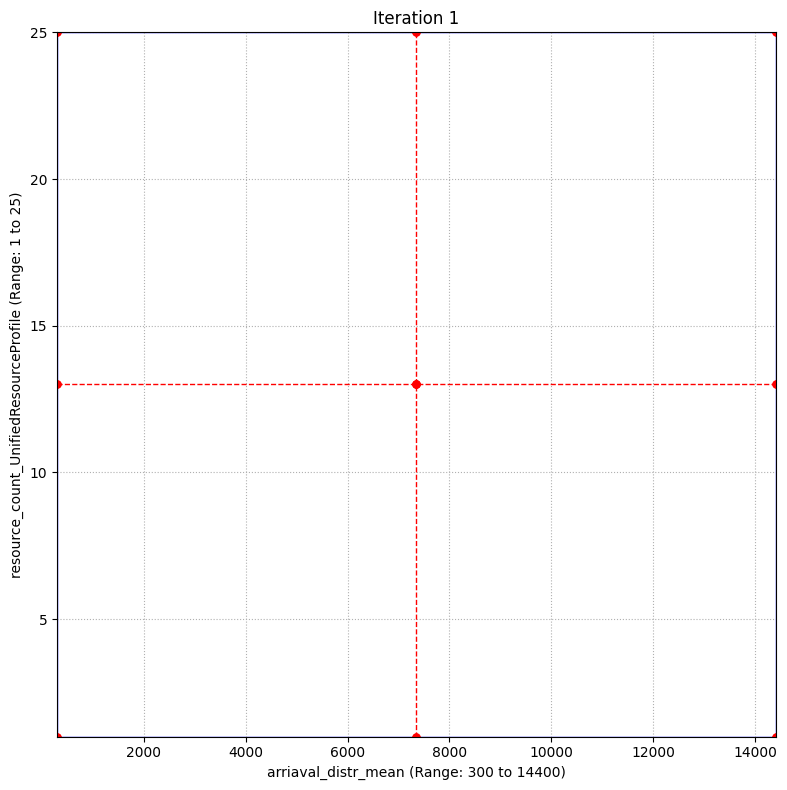

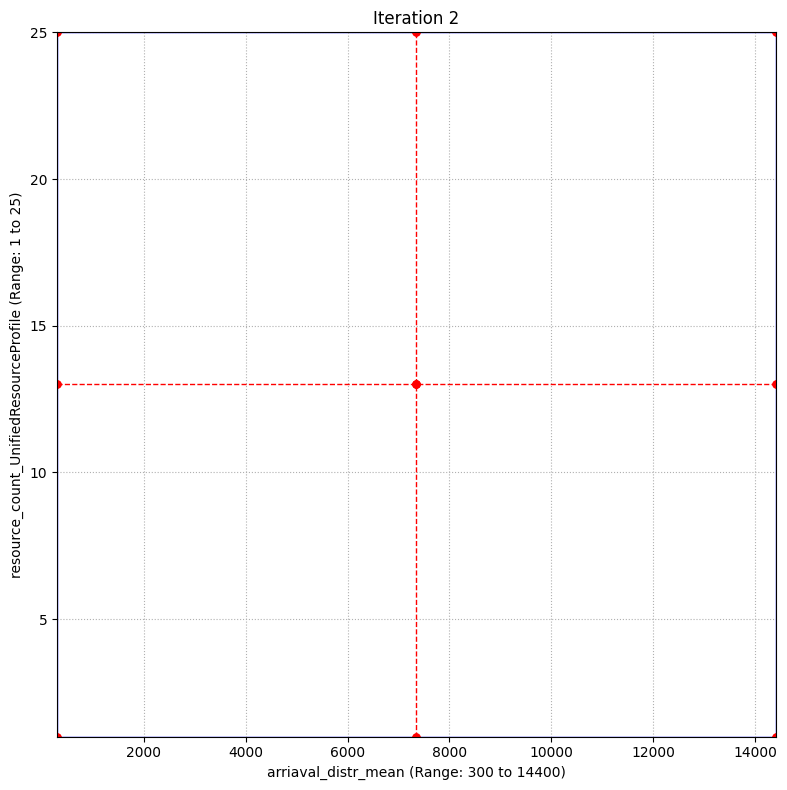

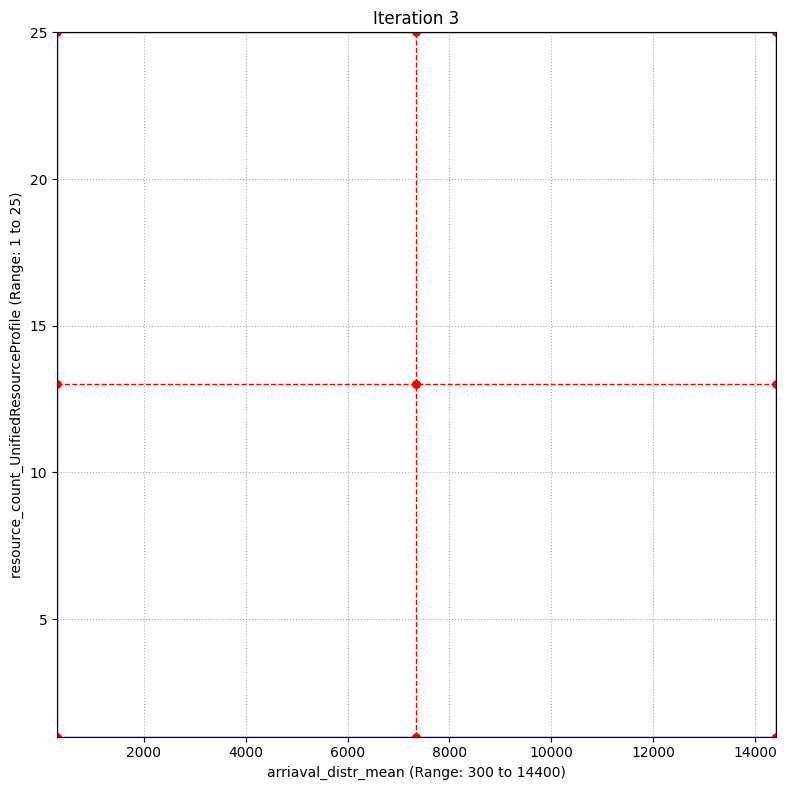

Number of nodes: 5, Number of sampled points: 9
{'sampled_points': 'data/LoanApp_SingleRole_fixDuration/output/20251112_183457/hyperquadtree_sampled_points.csv', 'nodes_visited': 'data/LoanApp_SingleRole_fixDuration/output/20251112_183457/hyperquadtree_nodes_visited.csv'}
Parameters saved to data/LoanApp_SingleRole_fixDuration/output/20251112_183457/params.json
Hyperquadtree nodes written to data/LoanApp_SingleRole_fixDuration/output/20251112_183457/hyperquadtree_sampled_points.csv
Nodes visited written to data/LoanApp_SingleRole_fixDuration/output/20251112_183457/hyperquadtree_nodes_visited.csv


In [411]:
from src.search_strategies.hyperquadtree import adaptive_hyperquadtree, write_hyperquadtree_nodes_to_file, write_nodes_visited_to_json

if 'hyperquadtree' in params['execute_strategy']:


    min_depth = params['strategies']['hyperquadtree']['min_depth']
    max_depth = params['strategies']['hyperquadtree']['max_depth']

    # Reset the temp JSON file
    create_temp_json(input_path=params['json_path'], output_path=None)

    # Call the hyperquadtree function
    all_nodes, sampled_points, nodes_visited, simulation_log = adaptive_hyperquadtree(
        set_sim_params_get_sim_stats,
        is_in_target_range,
        params,
        simulation_log,
        min_depth=min_depth,
        max_depth=max_depth
    )

    simulation_log.to_csv(params['simulation_log_path'], index=False)


    params['strategies']['hyperquadtree']['paths'] = {}
    params['strategies']['hyperquadtree']['paths']['sampled_points'] = os.path.join(params['experiment_output_dir'], 'hyperquadtree_sampled_points.csv')
    params['strategies']['hyperquadtree']['paths']['nodes_visited'] = os.path.join(params['experiment_output_dir'], 'hyperquadtree_nodes_visited.csv')
    if params['print_intermediate_results']:
        print(params['strategies']['hyperquadtree']['paths'])
    save_params(params)
    
    write_hyperquadtree_nodes_to_file(all_nodes, params)
    write_nodes_visited_to_json(nodes_visited, params)

In [412]:
nodes_visited

{0: {'all_nodes': 5, 'sampled_points': 4},
 1: {'all_nodes': 5, 'sampled_points': 9},
 2: {'all_nodes': 5, 'sampled_points': 9},
 3: {'all_nodes': 5, 'sampled_points': 9}}

#### Evaluation

In [413]:
from src.evaluation import evaluate_hyperquadtree_vs_simulation_log

df_results, summary = evaluate_hyperquadtree_vs_simulation_log(
    all_nodes,
    simulation_log,
    nodes_visited_dict = nodes_visited,
    params=params,
    depth_level = max_depth)

In [414]:
from src.evaluation import compute_and_save_quadtree_metrics
nodes_visited
compute_and_save_quadtree_metrics(all_nodes, simulation_log, params, nodes_visited, max_depth, 'hyperquadtree', output_file_name='hyperquadtree_metrics_over_depth.csv')

Quadtree metrics saved to data/LoanApp_SingleRole_fixDuration/output/20251112_183457/hyperquadtree_metrics_over_depth.csv


,TP,FP,TN,FN,precision_inrange,recall_inrange,accuracy,mcc,unclassified_fraction,total_points,classified_points,unclassified_points,depth,nodes_computed,classified_fraction
0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,100.0,0.0,100.0,1.0,4.0,0.0
1,0.0,0.0,87.0,13.0,NaN,0.0,0.87,NaN,0.0,100.0,100.0,0.0,2.0,9.0,1.0
2,0.0,0.0,87.0,13.0,NaN,0.0,0.87,NaN,0.0,100.0,100.0,0.0,3.0,9.0,1.0
3,0.0,0.0,87.0,13.0,NaN,0.0,0.87,NaN,0.0,100.0,100.0,0.0,4.0,9.0,1.0


#### Quadtree

In [415]:
from src.search_strategies.quadtree import adaptive_quadtree, plot_quadtree, write_nodes_visited_to_json, write_quadtree_nodes_to_file



 # Evaluating corner at (300, 1)
  Target PPI List: {'lead_time': [78102826.3], 'cost': [125954.44444444445]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (14400, 1)
  Target PPI List: {'lead_time': [45362544.5], 'cost': [125530.0]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (300, 25)
  Target PPI List: {'lead_time': [2239933.4], 'cost': [127458.33333333328]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (14400, 25)
  Target PPI List: {'lead_time': [53100.2], 'cost': [1334958.3333333333]}
  In Target Range: False, Direction: mixed
Node at depth 1 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 1 classified as out_range
 Subdividing node at depth 1...
True False


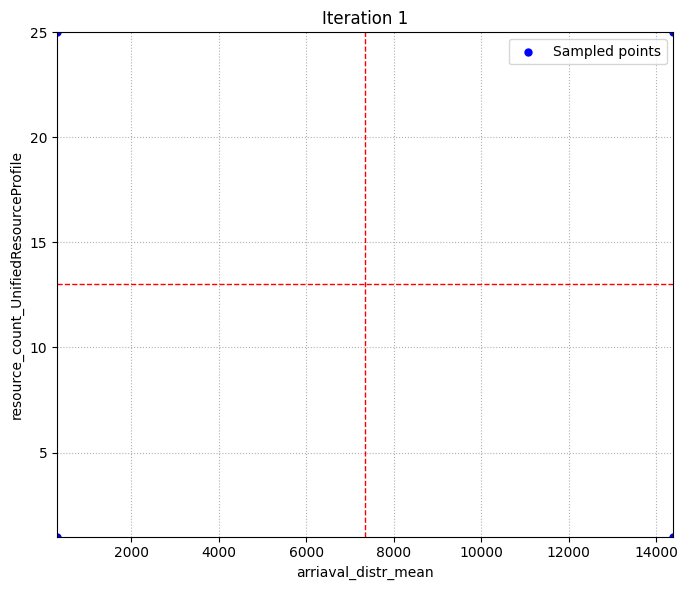



 # Evaluating corner at (300, 1)
  Target PPI List: {'lead_time': [78102826.3], 'cost': [125954.44444444445]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (7350.0, 1)
  Target PPI List: {'lead_time': [58838176.4], 'cost': [125782.22222222222]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (300, 13)
  Target PPI List: {'lead_time': [5158614.0], 'cost': [127703.33333333331]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (7350.0, 13)
  Target PPI List: {'lead_time': [55991.2], 'cost': [417018.3333333333]}
  In Target Range: False, Direction: mixed
Node at depth 2 - In Range: False, Out Range: True, Direction Range Same: True
Node at depth 2 classified as out_range


 # Evaluating corner at (7350.0, 1)
  Target PPI List: {'lead_time': [58838176.4], 'cost': [125782.22222222222]}
  In Target Range: False, Direction: mixed


 # Evaluating corner at (14400, 1)
  Target PPI List: {'lead_time': [45362544.5], 'cost': [125530.

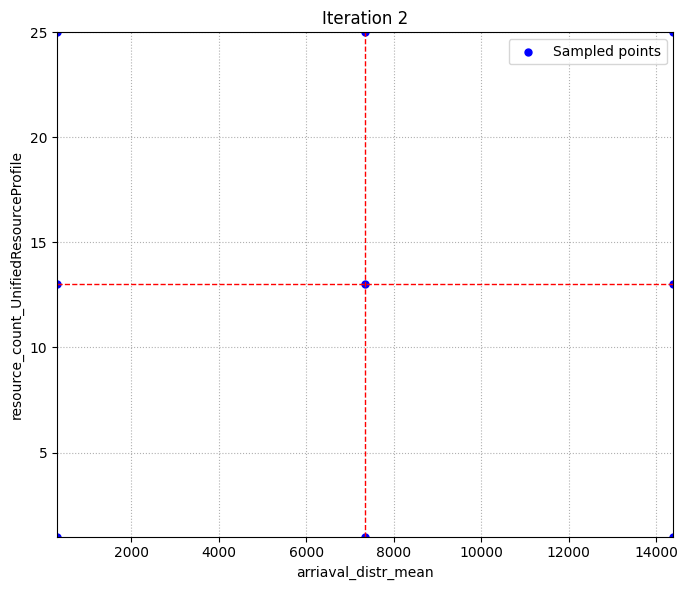

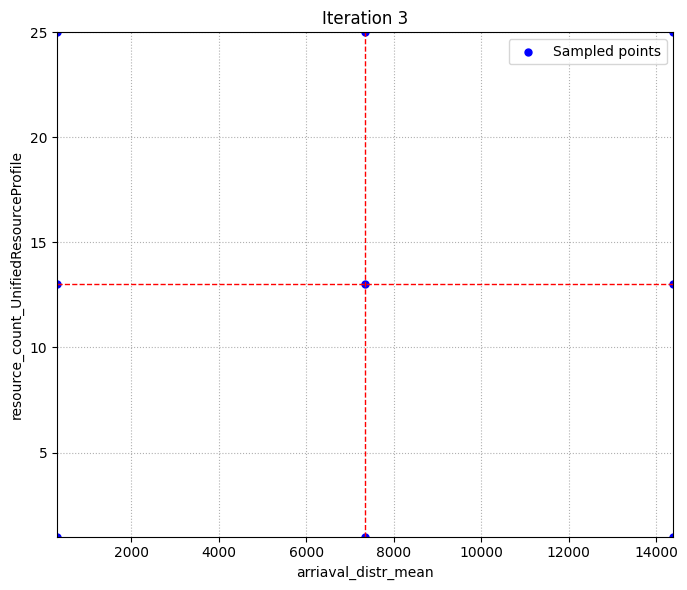

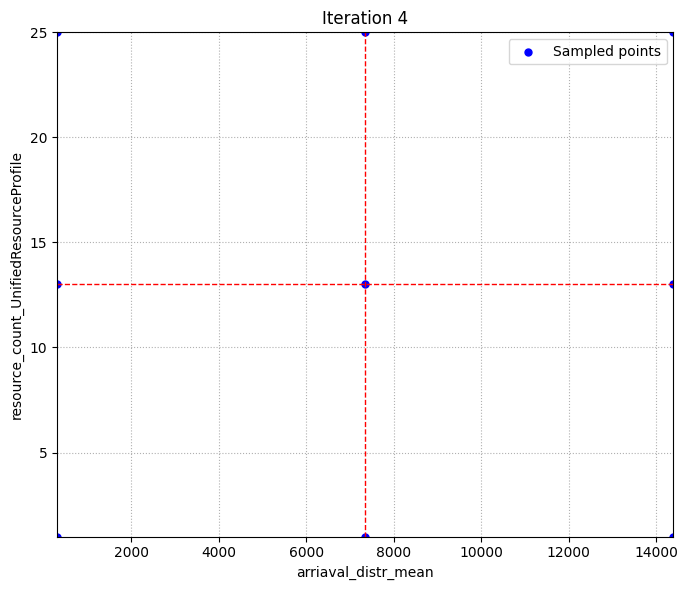

 Number of nodes: 5, Number of sampled points: 9


,algorithm,simulation_id,timestamp,target_range,status,target_ppis,target_ppi_means,target_ppi_dict,arriaval_distr_mean,resource_count_UnifiedResourceProfile
109,hyperquadtree,109,2025-11-12T17:35:53.108550Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 51767.6, 'cost': 694366.1111111109}","{'lead_time': [51767.6], 'cost': [694366.11111...",14400.0,13
110,quadtree,110,2025-11-12T17:35:54.257716Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 78102826.3, 'cost': 125954.44444...","{'lead_time': [78102826.3], 'cost': [125954.44...",300.0,1
111,quadtree,111,2025-11-12T17:35:54.773182Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 45362544.5, 'cost': 125530.0}","{'lead_time': [45362544.5], 'cost': [125530.0]}",14400.0,1
112,quadtree,112,2025-11-12T17:35:55.308539Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 2239933.4, 'cost': 127458.333333...","{'lead_time': [2239933.4], 'cost': [127458.333...",300.0,25
113,quadtree,113,2025-11-12T17:35:55.844600Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 53100.2, 'cost': 1334958.3333333...","{'lead_time': [53100.2], 'cost': [1334958.3333...",14400.0,25
114,quadtree,114,2025-11-12T17:35:56.495741Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 58838176.4, 'cost': 125782.22222...","{'lead_time': [58838176.4], 'cost': [125782.22...",7350.0,1
115,quadtree,115,2025-11-12T17:35:56.948394Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 5158614.0, 'cost': 127703.333333...","{'lead_time': [5158614.0], 'cost': [127703.333...",300.0,13
116,quadtree,116,2025-11-12T17:35:57.501165Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 55991.2, 'cost': 417018.3333333333}","{'lead_time': [55991.2], 'cost': [417018.33333...",7350.0,13
117,quadtree,117,2025-11-12T17:35:58.026833Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 52425.2, 'cost': 694178.3333333334}","{'lead_time': [52425.2], 'cost': [694178.33333...",14400.0,13
118,quadtree,118,2025-11-12T17:35:58.567024Z,"{'lead_time': [0, 65954.0], 'cost': [0, 230038...",False,"[lead_time, cost]","{'lead_time': 56763.8, 'cost': 801958.3333333336}","{'lead_time': [56763.8], 'cost': [801958.33333...",7350.0,25


Simulation log saved to data/LoanApp_SingleRole_fixDuration/output/20251112_183457/simulation_log.csv
Quadtree nodes written to data/LoanApp_SingleRole_fixDuration/output/20251112_183457/quadtree_sampled_points.csv
Nodes visited written to data/LoanApp_SingleRole_fixDuration/output/20251112_183457/quadtree_nodes_visited.csv
Parameters saved to data/LoanApp_SingleRole_fixDuration/output/20251112_183457/params.json


In [416]:
# params['print_intermediate_results'] = True
# params['in_out_criteria'] = 'confidence'
# params['nr_simulations_per_scenario'] = 3
# params['cases_to_simulate'] = 1000
# params['target_ppi'] = 'cycle_time' #'idle_cycle_time'
# params['ppi_range_factor']: 0.2
# params['execute_strategy'].append('quadtree')


from src.search_strategies.quadtree import adaptive_quadtree, plot_quadtree



if 'quadtree' in params['execute_strategy']:

    max_depth = params['strategies']['quadtree']['max_depth']
    min_depth = params['strategies']['quadtree']['min_depth']
    # max_depth = 5

    # Reset the temp JSON file
    create_temp_json(input_path=params['json_path'], output_path=None)

    if __name__ == "__main__":

        # Run adaptive refinement
        frontier, quadtree_nodes, sampled_points, nodes_visited, simulation_log = adaptive_quadtree(
            set_sim_params_get_sim_stats,
            is_in_target_range, 
            params, 
            simulation_log,
            min_depth=min_depth,
            max_depth=max_depth)

    display(simulation_log.tail(10))


    save_simulation_log(simulation_log, params)

    params['strategies']['quadtree']['paths'] = {}
    params['strategies']['quadtree']['paths']['sampled_points'] = os.path.join(params['experiment_output_dir'], 'quadtree_sampled_points.csv')
    params['strategies']['quadtree']['paths']['nodes_visited'] = os.path.join(params['experiment_output_dir'], 'quadtree_nodes_visited.csv')

    
    write_quadtree_nodes_to_file(quadtree_nodes, params)
    write_nodes_visited_to_json(nodes_visited, params)
    save_params(params)


In [417]:
nodes_visited

{0: {'all_nodes': 5, 'sampled_points': 4},
 1: {'all_nodes': 5, 'sampled_points': 9},
 2: {'all_nodes': 5, 'sampled_points': 9},
 3: {'all_nodes': 5, 'sampled_points': 9}}

In [418]:
for node in quadtree_nodes:
    # print(node.x_min, node.x_max, node.y_min, node.y_max, node.depth)
    print(node.depth, node.is_leaf, 'CORNER', node.corner_results)

1 False CORNER [(300, 1, False), (14400, 1, False), (300, 25, False), (14400, 25, False)]
2 True CORNER [(300, 1, False), (7350.0, 1, False), (300, 13, False), (7350.0, 13, False)]
2 True CORNER [(7350.0, 1, False), (14400, 1, False), (7350.0, 13, False), (14400, 13, False)]
2 True CORNER [(300, 13, False), (7350.0, 13, False), (300, 25, False), (7350.0, 25, False)]
2 True CORNER [(7350.0, 13, False), (14400, 13, False), (7350.0, 25, False), (14400, 25, False)]


## 3. Evaluation

In [419]:
from src.evaluation import generate_and_plot_quadtree_metrics, plot_quadtree_metrics_over_depth, evaluate_quadtree_vs_simulation_log, compute_and_save_quadtree_metrics

{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}
{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}
{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}
{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}


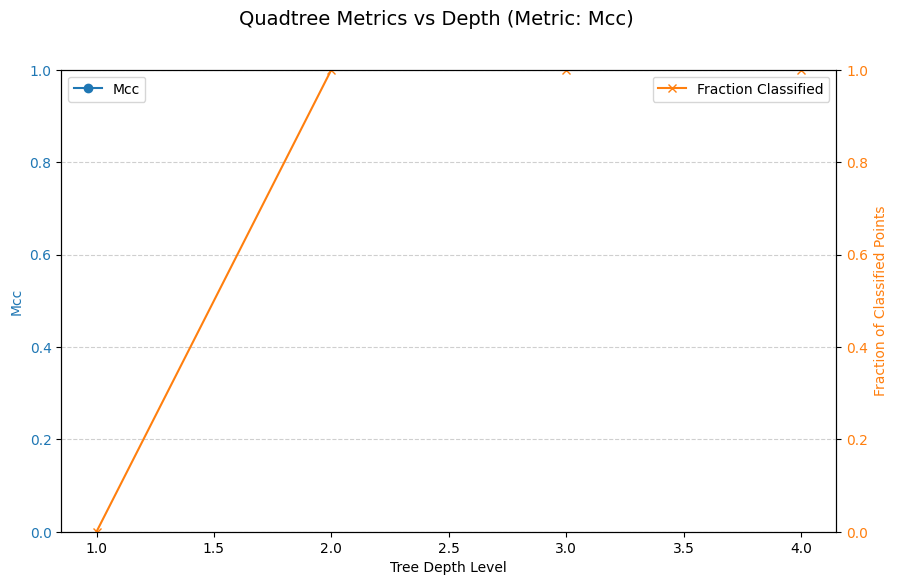

{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}
{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}
{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}
{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}


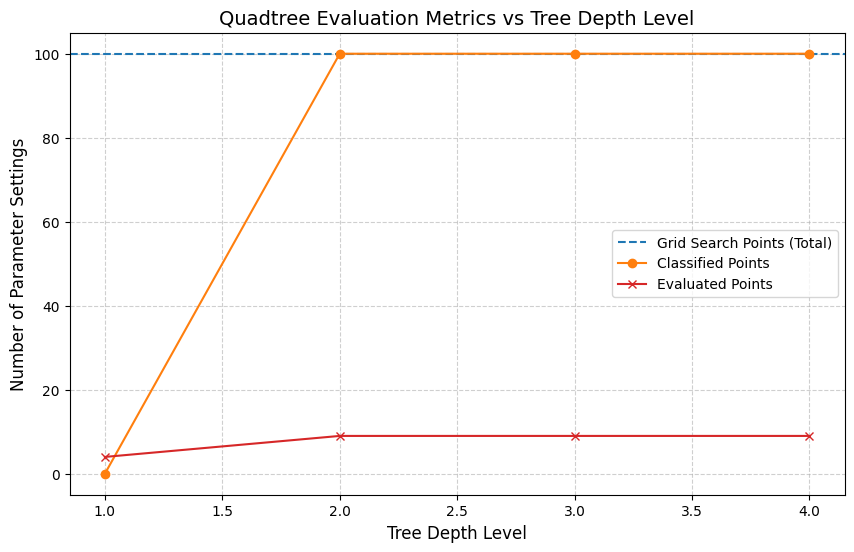

{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}
{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}
{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}
{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}
Quadtree metrics saved to data/LoanApp_SingleRole_fixDuration/output/20251112_183457/quadtree_metrics_over_depth.csv


,TP,FP,TN,FN,precision_inrange,recall_inrange,accuracy,mcc,unclassified_fraction,total_points,classified_points,unclassified_points,depth,nodes_computed,classified_fraction
0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,100.0,0.0,100.0,1.0,4.0,0.0
1,0.0,0.0,87.0,13.0,NaN,0.0,0.87,NaN,0.0,100.0,100.0,0.0,2.0,9.0,1.0
2,0.0,0.0,87.0,13.0,NaN,0.0,0.87,NaN,0.0,100.0,100.0,0.0,3.0,9.0,1.0
3,0.0,0.0,87.0,13.0,NaN,0.0,0.87,NaN,0.0,100.0,100.0,0.0,4.0,9.0,1.0


In [420]:

plot_quadtree_metrics_over_depth(quadtree_nodes, simulation_log, params, nodes_visited_dict=nodes_visited, max_depth=max_depth, metric="mcc")

generate_and_plot_quadtree_metrics(quadtree_nodes, simulation_log, params, nodes_visited_dict=nodes_visited, max_depth=max_depth)

# params['experiment_output_dir'] = os.path.join(base_path, 'output', '20251111_002602_1000_15n_LT')
compute_and_save_quadtree_metrics(quadtree_nodes, simulation_log, params, nodes_visited, max_depth, algorithm='quadtree', output_file_name='quadtree_metrics_over_depth.csv')

In [421]:
d= 4
df_results, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, nodes_visited, params, d)
display('depth: ', d)
display(df_results)
display(summary)

{0: {'all_nodes': 5, 'sampled_points': 4}, 1: {'all_nodes': 5, 'sampled_points': 9}, 2: {'all_nodes': 5, 'sampled_points': 9}, 3: {'all_nodes': 5, 'sampled_points': 9}}


'depth: '

4

,depth,status,x_min,x_max,y_min,y_max,n_points_total,n_points_true_inrange,n_points_true_outrange
0,2,out_range,300.0,7350.0,1,13,25,5,20
1,2,out_range,7350.0,14400.0,1,13,25,3,22
2,2,out_range,300.0,7350.0,13,25,25,5,20
3,2,out_range,7350.0,14400.0,13,25,25,0,25


depth_level                         4.00
total_nodes                         4.00
in_range_nodes                      0.00
out_range_nodes                     4.00
points_in_inrange_nodes             0.00
points_in_outrange_nodes          100.00
unique_points_classified          100.00
unclassified_points                 0.00
fraction_inrange_nodes_points       0.00
fraction_outrange_nodes_points      0.87
fraction_unclassified_points        0.00
nodes_visited                       5.00
nodes_computed                      9.00
dtype: float64